# Introduzione

Quanto segue è la realizzazione del progetto "House Prices Advanced Regression Techniques" prodotta da *Paolo Ciasco* & *Lorenzo Mancino*. Il work-flow deciso aprirà con un parte di feature engineering per poi testare vari modelli di apprendimento studiati all'interno del corso.
<!-- TBD -->



### Librerie Utilizzate

In [51]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Display multipli in fase di output

### Dati a Disposizione

Essendo una competizione di Kaggle e non essendo il nostro scopo partecipare ad essa abbiamo dovuto sistemare i dati a disposizione affinché avessimo un dataset consistente e propedeutico al nostro scopo. I dati forniti da Kaggle, infatti, sono costruiti affinché tutte le persone possano concorrere su uno stesso testset con i target dello stesso inseriti in un ulteriore file .csv. Il nostro lavoro è stato di unire il train ed il testset (riportando i target nello stesso) per generare un unico dataset su cui ci concentreremo.

In [61]:
train_set = pd.read_csv("./train.csv") # Caricamento del trainset
test_set = pd.read_csv("./test.csv") # Caricamento del testset
target_set = pd.read_csv("./sample_submission.csv") # Caricamento del file ove sono presenti i target

SalePrice = target_set.SalePrice # Selezione della colonna dei target
#test_set = test_set.join(SalePrice) # Immissione della colonna dei target nel testset
#test_set.to_csv('test.csv', index=False) # Sovrascrittura del testset con quello sistemato

# Unione del testset sistemato con il trainset

data_support = pd.read_csv('test.csv')
frames = [train_set, data_support]
final = pd.concat(frames)
final.to_csv('dataset.csv', index=False) # Export del file

# Caricamento del dataset ottenuto

data = pd.read_csv('dataset.csv')


### Analisi Dei Dati

Viene effettuata ora un'analisi dei dati per vedere cosa abbiamo a disposizione per svolgere il task: fare regressione sul prezzo delle case.

Come prima cosa si mostra con quanti elementi stiamo lavorando ed il numero delle feature fornite.

In [55]:
data.iloc[0:5, 0:5] # Porzione di dataframe

data.shape # Mostra le righe e le colonne del dataframe

data.iloc[1:3, 80:81] # Locazione del target

,Id,MSSubClass,MSZoning,LotFrontage,LotArea
0,1,60,RL,65.0,8450
1,2,20,RL,80.0,9600
2,3,60,RL,68.0,11250
3,4,70,RL,60.0,9550
4,5,60,RL,84.0,14260


(2919, 81)

,SalePrice
1,181500.0
2,223500.0


Il dataset fornito raccoglie $2919$ elementi e $81$ feature (includendo anche il target come 81esima feature). I dati forniti, inoltre, forniscono un utilissimo file .txt che descrive rapidamente le feature utilizzate.

Non essendo il dataset eccessivamente popolato, sebbene non verranno usate Neural Network, si decide di sfruttare la k-fold validation.
Essendo le feature un numero veramente elevato per una regressione del prezzo di una casa si decide di attuare la cosidetta Feature Engineering. 

### Feature Engineering

Come prima cosa si controlla l'eventuale assenza completa di dati in qualche colonna

In [34]:
# Iterazione su tutte le colonne per controllare l'eventuale presenza di valori nulli su tutta l'intera colonna

for i in data.columns:
    if data[i].isnull().all():
        print(data[i])
    

Sfruttando la libreria *missingno* vogliamo mostrare una matrice di valori mancanti per trovare eventuali feature poco popolate su cui fare un'analisi ulteriore.

<AxesSubplot:>

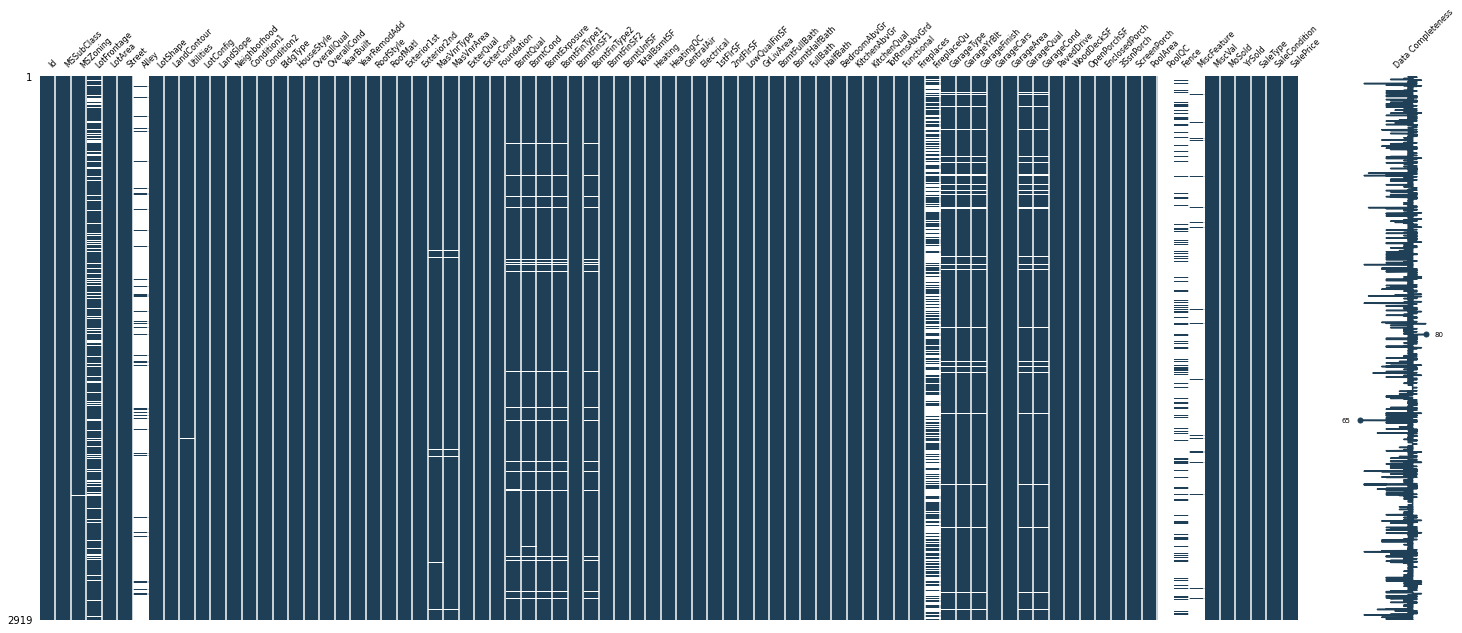

In [56]:
msno.matrix(data, labels=True, fontsize=8, color = (0.12,0.25,0.34))


La prima feature che notiamo essere poco popolata è **Alley**, ovvero (seguendo le istruzioni fornite come specificato poco prima) la feature riguardante l'ingresso o meno da dei vicoli e, se presente, il materiale usato per lo stesso. In questo caso non è salutare eliminare direttamente la feature perché in realta i valori mancanti indicano il fatto che la casa non ha ingressi da vicoli che, in un ipotetico prezzo finale, è una caratteristica che è rilevante. Riguardo questo, utilizzeremo un metodo per "fillare" i valori nulli in modo tale che l'informazione venga preservata.

La seconda feature che coglie la nostra attenzione è **FireplaceQu**, ovvero la feature che esprime la qualità del camino se presente. Qui, a differenza di prima, ci annotiamo questa feature come potenzialmente "inutile" perchè è presente una ulteriore feature (**Fireplaces**) che descrive il numero di camini presenti nella casa. Sfrutteremo in seguito un'analisi di correlazione per confermare o meno questa ipotesi.

La terza feature che vediamo essere poco popolata è **PoolQC**, ovvero la feature che rappresenta la qualità della piscina se presente. Anche qui la feature viene memorizzata perché presente un'altra feature (**PoolArea**) che esprime i metri quadri della piscina. Ulteriori analisi e ragionamenti in seguito all'analisi di correlazione.

La quarta feature interessante è **Fence**, ovvero la feature che esprime la presenza o meno di una recizione e, se presente,la sua qualità. Come nel primo caso non possiamo ragionare su questa feature in quanto la presenza di una recizione è sicuramente un elemento a favore o meno di un prezzo.

L'ultima feature è **MiscFeature**, ovvero la feature che descrive elementi addizionali di una casa(ad es. Ascensore, Campo da Tennis, ...). Prendiamo nota di questa feature in quanto è presente una ulteriore feature (**MiscVal**) che esprime il valore totale di tutti gli elementi addizionali presenti. Anche qui verranno eseguite ulteriori analisi.


In [62]:
# Transform categorical feature into number


#data.fillna(0, inplace=True)

"""categorical_nominal_features = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig",
                                "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
                                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                                "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical",
                                "Functional", "GarageType", "PavedDrive", "MiscFeature", "SaleType",
                                "SaleCondition", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",
    "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish", "Fence"]

categorical_ordinal_features = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",
    "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish", "Fence"
]


quality_scale_dict = {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
BstmExposure_dict = {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
BsmtFinType_dict = {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
GarageFinish_dict = {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3}
Fence_dict = {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}

# contiene coppie del tipo feature:scala usata
feature_scale_dict = {
    "ExterQual": quality_scale_dict,
    "ExterCond": quality_scale_dict,
    "BsmtQual": quality_scale_dict,
    "BsmtCond": quality_scale_dict,
    "HeatingQC": quality_scale_dict,
    "KitchenQual": quality_scale_dict,
    "FireplaceQu": quality_scale_dict,
    "GarageQual": quality_scale_dict,
    "GarageCond": quality_scale_dict,
    "PoolQC": quality_scale_dict,
    "BsmtExposure": BstmExposure_dict,
    "BsmtFinType1": BsmtFinType_dict,
    "BsmtFinType2": BsmtFinType_dict,
    "GarageFinish": GarageFinish_dict,
    "Fence": Fence_dict
}
"""
"""for feature in categorical_nominal_features:
    # change enum values to integer
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])

for feature in categorical_ordinal_features:
    dict = feature_scale_dict[feature]

    data[feature] = data[feature].apply(lambda x: dict[x])"""

le = LabelEncoder()
data["Alley"] 
data["Alley"] = le.fit_transform(data["Alley"])

data["Alley"]



'categorical_nominal_features = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig",\n                                "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",\n                                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",\n                                "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical",\n                                "Functional", "GarageType", "PavedDrive", "MiscFeature", "SaleType",\n                                "SaleCondition", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",\n    "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish", "Fence"]\n\ncategorical_ordinal_features = [\n    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual",\n    "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinT

'for feature in categorical_nominal_features:\n    # change enum values to integer\n    le = LabelEncoder()\n    data[feature] = le.fit_transform(data[feature])\n\nfor feature in categorical_ordinal_features:\n    dict = feature_scale_dict[feature]\n\n    data[feature] = data[feature].apply(lambda x: dict[x])'

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21      Grvl
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
30      Pave
31       NaN
32       NaN
33       NaN
34       NaN
35       NaN
36       NaN
37       NaN
38       NaN
39       NaN
40       NaN
41       NaN
42       NaN
43       NaN
44       NaN
45       NaN
46       NaN
47       NaN
48       NaN
49       NaN
50       NaN
51       NaN
52       NaN
53       NaN
54       NaN
55       NaN
56      Pave
57       NaN
58       NaN
59       NaN
60       NaN
61       NaN
62       NaN
63       NaN
64       NaN
65       NaN
66       NaN
67       NaN
68       NaN
69       NaN
70       NaN
71       NaN
72       NaN
73       NaN
74       NaN
75       NaN
76       NaN

0       2
1       2
2       2
3       2
4       2
5       2
6       2
7       2
8       2
9       2
10      2
11      2
12      2
13      2
14      2
15      2
16      2
17      2
18      2
19      2
20      2
21      0
22      2
23      2
24      2
25      2
26      2
27      2
28      2
29      2
30      1
31      2
32      2
33      2
34      2
35      2
36      2
37      2
38      2
39      2
40      2
41      2
42      2
43      2
44      2
45      2
46      2
47      2
48      2
49      2
50      2
51      2
52      2
53      2
54      2
55      2
56      1
57      2
58      2
59      2
60      2
61      2
62      2
63      2
64      2
65      2
66      2
67      2
68      2
69      2
70      2
71      2
72      2
73      2
74      2
75      2
76      2
77      2
78      2
79      0
80      2
81      2
82      2
83      2
84      2
85      2
86      2
87      1
88      2
89      2
90      2
91      2
92      0
93      2
94      2
95      2
96      2
97      2
98      2
99      2


In [11]:

corr = data.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm').to_html('asd.html')


soglia0 = .60
soglia1 = .70
soglia2 = .80
soglia3 = .90
     


[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia0)) if i < j]
[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia1)) if i < j]
#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia2)) if i < j]
#[f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) >= soglia3)) if i < j]


['YearBuilt and YearRemodAdd',
 'YearBuilt and GarageYrBlt',
 'YearRemodAdd and GarageYrBlt',
 'Exterior1st and Exterior2nd',
 'BsmtFinType1 and BsmtFinSF1',
 'BsmtFinType2 and BsmtFinSF2',
 'TotalBsmtSF and 1stFlrSF',
 'GrLivArea and TotRmsAbvGrd',
 'Fireplaces and FireplaceQu',
 'GarageCars and GarageArea',
 'GarageQual and GarageCond',
 'PoolArea and PoolQC',
 'MiscFeature and MiscVal']